## 2018 Ebola outbreak in the DRC

Reproducing [Christian Althaus' results](https://github.com/calthaus/Ebola/tree/master/DRC%20%28GitHub%202018%29) with a stochastic model.

This notebook simply generates the data that will feed the accompanying interactive dashboard. For details on the estimation procedure itself, please refer to the [repository of `sdeparams`](https://github.com/cparrarojas/sde-parameter-estimation) and the examples therein.

In [1]:
import numpy as np
import pandas as pd

from scipy.integrate import odeint
from scipy.optimize import differential_evolution

import sdeparams.sdeparams as sdeparams

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')
sns.set(palette='colorblind')
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
ncolours = len(plt.rcParams['axes.prop_cycle'])
colours = [list(plt.rcParams['axes.prop_cycle'])[i]['color'] for i in range(ncolours)]

import warnings
warnings.filterwarnings('ignore')

### Model setup

Matrices defining the linear-noise approximation.

In [2]:
ndim = 3
N = 1.0e6
sigma = 1./9.31
gamma = 1./7.41
tau = 28.

def A(x, t, *params):
    e0, i0, beta, k = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    delta = np.maximum(t-tau,0)
    return np.array([-beta*np.exp(-k*delta)*s*i/N, beta*np.exp(-k*delta)*s*i/N - sigma*e, sigma*e - gamma*i])

def B(x, t, *params):
    e0, i0, beta, k = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    delta = np.maximum(t-tau,0)
    return np.array([[beta*np.exp(-k*delta)*s*i/N, -beta*np.exp(-k*delta)*s*i/N, 0.],
                     [-beta*s*np.exp(-k*delta)*i/N, beta*np.exp(-k*delta)*s*i/N + sigma*e, -sigma*e],
                     [0., -sigma*e, sigma*e + gamma*i]])

def J(x, t, *params):
    e0, i0, beta, k = params
    s, e, i = np.maximum(x, np.zeros(ndim))
    delta = np.maximum(t-tau,0)
    return np.array([[-beta*np.exp(-k*delta)*i/N, 0., -beta*np.exp(-k*delta)*s/N],
                     [beta*np.exp(-k*delta)*i/N, -sigma, beta*np.exp(-k*delta)*s/N],
                     [0., sigma, -gamma]])

### Parameter estimation

In [4]:
data = pd.read_csv('https://raw.githubusercontent.com/calthaus/Ebola/master/DRC%20(GitHub%202018)/Ebola_outbreak_DRC2018_data.csv')
data.Date = pd.to_datetime(data.Date)

In [5]:
data.head()

,Date,Cumulative,Cases
0,2018-04-05,1,1
1,2018-04-06,1,0
2,2018-04-07,1,0
3,2018-04-08,2,1
4,2018-04-09,2,0


In [6]:
observations = (N - data.Cumulative.values, data.index.values)

zimmer = sdeparams.Zimmer(A, B, J, observations, ndim, n_obs=1, estimate_N=False, N=1)

In [7]:
bounds = [(0., 0.), (1., 1.), (0.1, 5.), (0.01, 2.)]

estimation = differential_evolution(zimmer.costfn, bounds)

Best fit parameters

In [8]:
params_estim = tuple(estimation.x)

Text(0,0.5,'$R_t$')

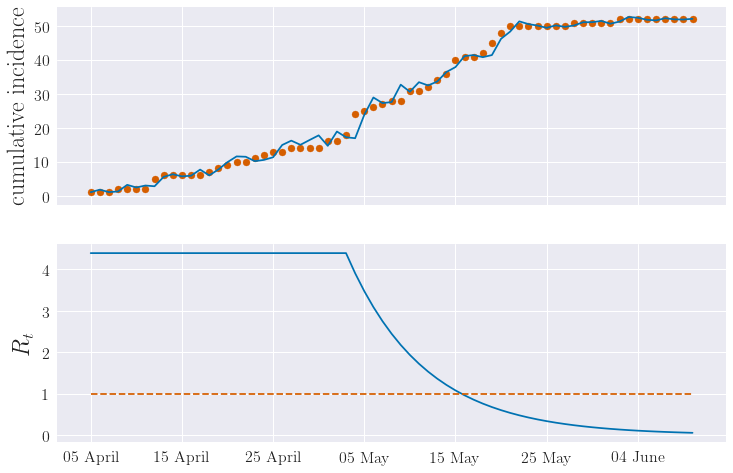

In [10]:
fig, axes = plt.subplots(2,1, figsize=(12,8), sharex=True)
axes[0].plot(observations[1],N-zimmer.reconstruct(params_estim)[:,0])
axes[0].scatter(observations[1],N-observations[0],c=colours[2])
axes[1].set_xticks(np.linspace(0,60,7))
axes[1].set_xticklabels(data.Date.dt.strftime('%d %B').values[::10])
axes[0].set_ylabel('cumulative incidence', fontsize=24)
axes[1].plot(observations[1],(params_estim[2]/gamma)*np.exp(-params_estim[3]*np.maximum(observations[1]-tau,0)))
axes[1].plot(observations[1],np.ones(observations[1].shape), c=colours[2], linestyle='--')
axes[1].set_ylabel('$R_t$', fontsize=24)

### Generating app data

In [9]:
params_estim

(0.0, 1.0, 0.5925136453078155, 0.11722573760818489)

In [164]:
betas = np.linspace(.2,1.,50)
ks = np.linspace(0.07,0.17,50)

likelihood = []
for b in betas:
    for k in ks:
        likelihood.append([b, k, np.exp(-zimmer.costfn((0.,1.,b,k)))])
likelihood=np.array(likelihood)

In [165]:
likelihood = np.vstack((likelihood, np.array([[params_estim[2], params_estim[3], np.exp(-zimmer.costfn(params_estim))]])))

In [166]:
df_like = pd.DataFrame(likelihood, columns=['beta', 'k', 'likelihood'])
df_like.likelihood = df_like.likelihood/(df_like.likelihood.sum())

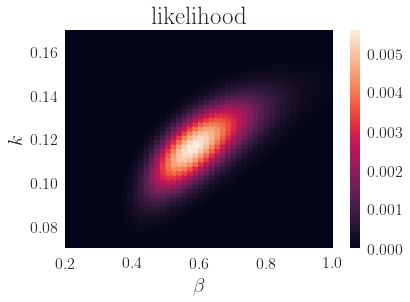

In [167]:
points = plt.scatter(df_like.beta, df_like.k, c=df_like.likelihood/(df_like.likelihood.sum()), s=50)
#plt.scatter([params_estim[2]],[params_estim[3]], marker='X', s=200)
plt.xlim(0.2,1.)
plt.ylim(0.07,0.17)
plt.xlabel(r'$\beta$', fontsize=20)
plt.ylabel(r'$k$', fontsize=20)
plt.title(r'likelihood', fontsize=25)
plt.colorbar(points)

In [52]:
def unit_vector(i, D):
    '''Returns (i+1)-th unit vector of dimension D'''
    out = np.zeros(D)
    out[i] = 1
    return out

def transition_rates(x, beta_t):
    '''Transition rates for every possible reaction'''
    return np.array([beta_t*x[0]*x[2]/N, 
                     sigma*x[1], 
                     gamma*x[2]])

nu = np.array([unit_vector(1, ndim) - unit_vector(0, ndim), unit_vector(2, ndim) - unit_vector(1, ndim),
               -unit_vector(2, ndim)], dtype=int)

In [53]:
def path(x, t, beta_t):
    dt = t[1]-t[0]
    x_t = []
    for i in range(len(t)):
        x_t.append(x)
        rates = transition_rates(x, beta_t[i])
        n = len(rates)
        firings = np.random.poisson(np.maximum(rates, np.zeros(n))*dt)
        change = np.sum([firings[i]*nu[i] for i in range(len(rates))], axis=0)
        x = x + change
        
    x_t = np.array(x_t)
    
    return x_t

In [117]:
t_forecast = np.linspace(66.,100.,17000)
newdays = t_forecast[::500].astype(int)
alldays = np.append(observations[1], newdays)

In [171]:
def R_t(beta, k, t):
    if t <= tau:
        return beta/gamma
    return beta*np.exp(-k*(t-tau))/gamma
R_t = np.vectorize(R_t)

In [201]:
app_data = pd.DataFrame()
for i, row in df_like.iterrows():
    
    beta = row.beta
    k = row.k
    l = row.likelihood
    
    app_data_new = pd.DataFrame({'time': alldays, 'beta': beta*np.ones(len(alldays)), 'k': k*np.ones(len(alldays)),
                             'likelihood': l*np.ones(len(alldays)), 'R_t': R_t(beta, k, alldays)})
    
    beta_t = beta*np.exp(-k*(t_forecast-tau))
    
    params = (0.,1.,beta,k)
    reconstruct = zimmer.reconstruct(params).astype(int)
    x0 = [observations[0][-1], reconstruct[-1,1], reconstruct[-1,2]]
    
    results_s = pd.DataFrame(index=newdays)
    results_e = pd.DataFrame(index=newdays)
    results_i = pd.DataFrame(index=newdays)

    for j in range(50):
    
        forecast = path(x0, t_forecast, beta_t)[::500]
    
        results_s[str(j)] = forecast[:,0]
        results_e[str(j)] = forecast[:,1]
        results_i[str(j)] = forecast[:,2]
        
    app_data_new['cumulative'] = N - np.concatenate((reconstruct[:,0],results_s.mean(axis=1).values))
    app_data_new['cumulative p'] = N - np.concatenate((reconstruct[:,0],(results_s.mean(axis=1)-results_s.std(axis=1)).values))
    app_data_new['cumulative m'] = N - np.concatenate((reconstruct[:,0],(results_s.mean(axis=1)+results_s.std(axis=1)).values))
    app_data_new['E'] = np.concatenate((reconstruct[:,1],(results_e.mean(axis=1)).values))
    app_data_new['E p'] = np.concatenate((reconstruct[:,1],(results_e.mean(axis=1)+results_e.std(axis=1)).values))
    app_data_new['E m'] = np.concatenate((reconstruct[:,1],np.maximum((results_e.mean(axis=1)-results_e.std(axis=1)).values, 0)))
    app_data_new['I'] = np.concatenate((reconstruct[:,2],(results_i.mean(axis=1)).values))
    app_data_new['I p'] = np.concatenate((reconstruct[:,2],(results_i.mean(axis=1)+results_i.std(axis=1)).values))
    app_data_new['I m'] = np.concatenate((reconstruct[:,2],np.maximum((results_i.mean(axis=1)-results_i.std(axis=1)).values, 0)))
    
    app_data = pd.concat([app_data, app_data_new], axis=0)

In [202]:
app_data.to_csv('app_data.csv', index=False)

In [203]:
df_like.to_csv('likelihood.csv', index=False)